__1. Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.__

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import itertools

from statsmodels.tsa.statespace.sarimax import SARIMAX
from  statsmodels.graphics.tsaplots import plot_pacf, plot_acf

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0]).resample('M').mean()
data.head(7)

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-31,31075.399731,2002.0,1.0,16.020188,1.0,16.020188,2.873486,2.905787,11.515478,0.063257,0.032301,0.064603
2002-02-28,30239.166667,2002.0,2.0,14.500000,1.0,45.500000,7.071429,3.000000,11.500000,0.035714,0.035714,0.035714
2002-03-31,28875.256720,2002.0,3.0,16.000000,1.0,75.000000,11.258065,3.193548,11.500000,0.000000,0.000000,0.000000
2002-04-30,28534.731572,2002.0,4.0,15.511822,2.0,105.511822,15.668985,2.828929,11.511822,0.000000,0.000000,0.000000
2002-05-31,28073.653226,2002.0,5.0,16.000000,2.0,136.000000,20.000000,3.000000,11.500000,0.032258,0.032258,0.032258
2002-06-30,33585.919444,2002.0,6.0,15.500000,2.0,166.500000,24.333333,3.166667,11.500000,0.000000,0.000000,0.000000
2002-07-31,38041.896505,2002.0,7.0,16.000000,3.0,197.000000,28.741935,2.806452,11.500000,0.032258,0.032258,0.032258


__2. Подберите параметры модели SARIMAX для этого ряда.__

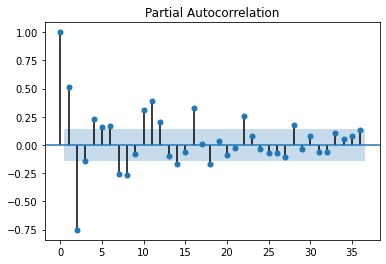

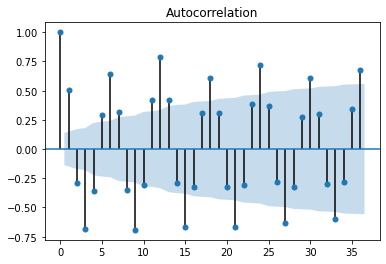

In [3]:
years = 3

plot_pacf(data['PJME_MW'].values, lags=12*years)
plot_acf(data['PJME_MW'].values, lags=12*years)
plt.show()

In [4]:
p = range(0, 3)
d = [1] #  поскольку ряд интегрированный 1 порядка (исходя из предыдущих уроков)
q = [0, 1, 3]

pdq = list(itertools.product(p, d, q))

ps = [0, 2]
ds = [0, 1]
qs = [0, 1, 2]
s = 6

seasonal_pdq = [(x[0], x[1], x[2], s) for x in list(itertools.product(ps, ds, qs))]

n_all_iter = len(p)*len(d)*len(q)*len(ps)*len(ds)*len(qs)
print(f'Общее количество вариантов: {n_all_iter}')

Общее количество вариантов: 108


In [5]:
n_test_months = 24

best_aic = float("inf")

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(data['PJME_MW'].values[:-n_test_months],
                            order=param,
                            seasonal_order=param_seasonal,
                            enforce_stationarity=False,
                            enforce_invertibility=False)

            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_param = param
                best_seas_param = param_seasonal
                
#             print(f'{i}/{n_all_iter}: SARIMA{param}x{param_seasonal} - AIC: {results.aic}')
        except Exception as e: 
            print(e)
            
print(f'Best AIC: {best_aic} - SARIMA{best_param}x{best_seas_param}')

Best AIC: 2711.41990619829 - SARIMA(0, 1, 3)x(2, 1, 2, 6)


In [6]:
best_model = SARIMAX(data['PJME_MW'].values[:-n_test_months],
                     order=best_param,
                     seasonal_order=best_seas_param,
                     enforce_stationarity=False,
                     enforce_invertibility=False)

best_results = best_model.fit()
print(best_results.summary().tables[0], '\n')
print(best_results.summary().tables[1])

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                  176
Model:             SARIMAX(0, 1, 3)x(2, 1, [1, 2], 6)   Log Likelihood               -1347.710
Date:                                Wed, 13 May 2020   AIC                           2711.420
Time:                                        02:16:18   BIC                           2735.663
Sample:                                             0   HQIC                          2721.268
                                                - 176                                         
Covariance Type:                                  opg                                         

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5849      0.096     -6.118      0.000      -0.772      -0.397
ma

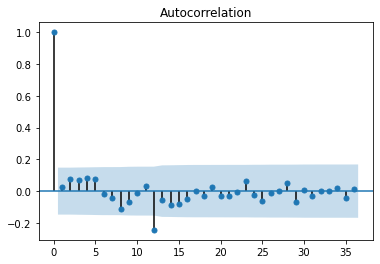

In [7]:
plot_acf(best_results.resid, lags=12*years)
plt.show()

__3. Сделайте вывод о том, как изменилась модель по сравнению с недельной.__

Модель лучше той, которая была для недельной выборки, т.к. информационный критерий Акаике ниже (он учитывает не только приближение модели, но количество используемых параметров). Коэффициенты имеют большие значения, а автокорреляция остатков имеет незначимые значения.

__4.1 Постройте ACF, PACF и модель ARIMA для BRENT (недельный ресемплинг).__

In [8]:
brent = pd.read_csv('my_BRENT2019.csv', index_col=[0], parse_dates=[0]).resample('W').mean()
brent.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-05,76.616000,2010.0,9.000000,3.000000,3.000000,246.000000,35.0,4.000000,0.000000,0.2,0.000000
2010-09-12,77.673333,2010.0,9.000000,8.500000,3.000000,251.500000,36.0,2.500000,0.166667,0.0,0.166667
2010-09-19,78.693333,2010.0,9.000000,15.666667,3.000000,258.666667,37.0,2.666667,0.000000,0.0,0.000000
2010-09-26,78.518333,2010.0,9.000000,22.666667,3.000000,265.666667,38.0,2.666667,0.000000,0.0,0.000000
2010-10-03,81.211667,2010.0,9.333333,19.666667,3.333333,272.666667,39.0,2.666667,0.000000,0.0,0.000000


In [9]:
print(f"Количество пустых строк: {brent['Значение'].isnull().sum()}")
print(brent[brent['Значение'].isnull()].index)

Количество пустых строк: 1
DatetimeIndex(['2011-10-16'], dtype='datetime64[ns]', name='Дата', freq='W-SUN')


In [10]:
brent = brent.fillna(method='pad')

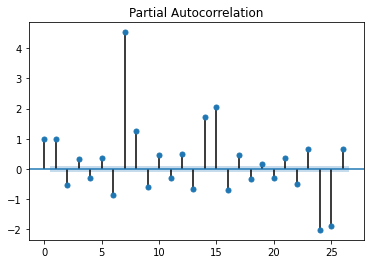

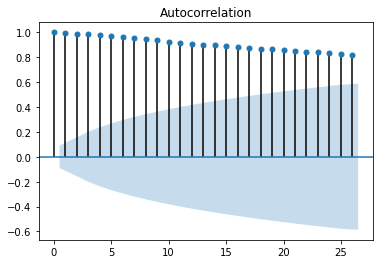

In [11]:
weeks = 26

plot_pacf(brent['Значение'].values, lags=weeks)
plot_acf(brent['Значение'].values, lags=weeks)
plt.show()

In [12]:
from statsmodels.tsa.stattools import adfuller as ADF

# определим порядок интегрированности ряда для определения параметра d
print(f"p-value для 0-порядка: {ADF(brent['Значение'].values, regression = 'ctt')[1]}")
print(f"p-value для 1-порядка: {ADF(brent['Значение'].diff().fillna(0).values, regression = 'ctt')[1]}")

p-value для 0-порядка: 0.40279156513944053
p-value для 1-порядка: 4.1878085191520404e-10


In [13]:
from statsmodels.tsa.arima_model import ARIMA

Разобъем ряд на тренировочный и тестовый, обучим модель на тренировочном и предскажем тестовый, после чего переобучим модель на всем ряде и предскажем будущие значения.

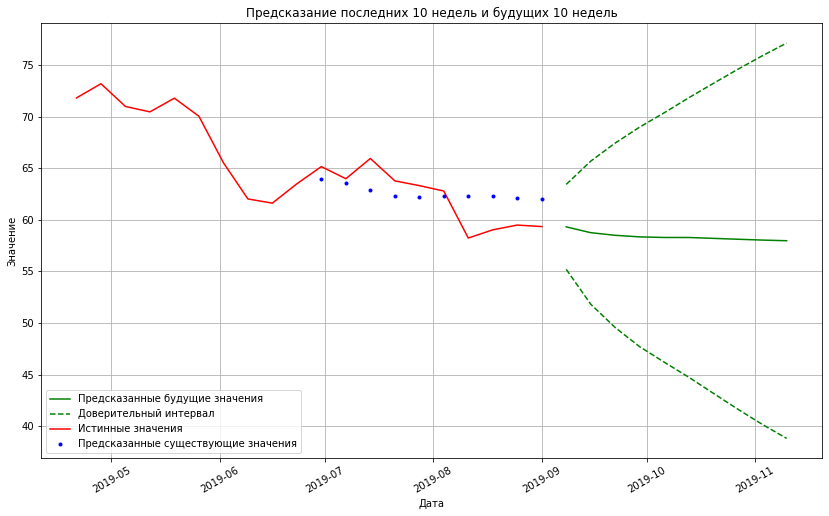

In [14]:
plt.figure(figsize =(14, 8))

N = 10
p, d, q = 7, 1, 0

model_pred = ARIMA(brent['Значение'][:-N], order=(p, d, q)).fit(disp=-1)

model_future = ARIMA(brent['Значение'], order=(p, d, q)).fit(disp=-1)

y_pred = model_pred.predict(len(brent['Значение'][:-N]), len(brent['Значение']) - 1, typ='levels')
y_forecast = model_future.forecast(N)

plt.plot(pd.date_range(start=brent.index[-1], periods=N+1, freq='W')[1:], y_forecast[0], 'g',
         label ='Предсказанные будущие значения')
plt.plot(pd.date_range(start=brent.index[-1], periods=N+1, freq='W')[1:], y_forecast[2][:, 0],'--g',
         label = 'Доверительный интервал')
plt.plot(pd.date_range(start=brent.index[-1], periods=N+1, freq='W')[1:], y_forecast[2][:, 1],'--g')

plt.plot(brent['Значение'][-2*N:],'r',label ='Истинные значения')
plt.plot(y_pred,'.b',label ='Предсказанные существующие значения')

plt.xlabel('Дата')
plt.ylabel('Значение')
plt.title(f'Предсказание последних {N} недель и будущих {N} недель')
plt.grid()
plt.xticks(rotation=30)
plt.legend()
plt.show()

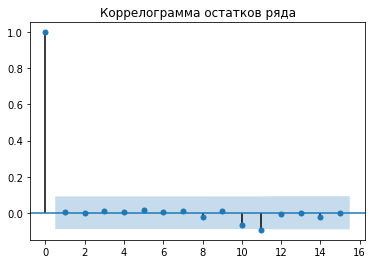

In [15]:
plot_acf(model_future.resid, lags=15)
plt.title('Коррелограмма остатков ряда')
plt.show()

__4.2 Постройте ACF, PACF и модель ARIMA для СOVID_19 (по любой стране кроме Китая на дневных графиках).__

Построим датасет по США

In [16]:
covid = pd.read_csv('covid_19_data.csv', parse_dates=[1])
covid.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,2020-01-22,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,2020-01-22,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,2020-01-22,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,2020-01-22,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,2020-01-22,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [17]:
print('Полный список стран:')
covid['Country/Region'].unique()

Полный список стран:


array(['Mainland China', 'Hong Kong', 'Macau', 'Taiwan', 'US', 'Japan',
       'Thailand', 'South Korea', 'Singapore', 'Philippines', 'Malaysia',
       'Vietnam', 'Australia', 'Mexico', 'Brazil', 'Colombia', 'France',
       'Nepal', 'Canada', 'Cambodia', 'Sri Lanka', 'Ivory Coast',
       'Germany', 'Finland', 'United Arab Emirates', 'India', 'Italy',
       'UK', 'Russia', 'Sweden', 'Spain', 'Belgium', 'Others', 'Egypt',
       'Iran', 'Israel', 'Lebanon', 'Iraq', 'Oman', 'Afghanistan',
       'Bahrain', 'Kuwait', 'Austria', 'Algeria', 'Croatia',
       'Switzerland', 'Pakistan', 'Georgia', 'Greece', 'North Macedonia',
       'Norway', 'Romania', 'Denmark', 'Estonia', 'Netherlands',
       'San Marino', ' Azerbaijan', 'Belarus', 'Iceland', 'Lithuania',
       'New Zealand', 'Nigeria', 'North Ireland', 'Ireland', 'Luxembourg',
       'Monaco', 'Qatar', 'Ecuador', 'Azerbaijan', 'Czech Republic',
       'Armenia', 'Dominican Republic', 'Indonesia', 'Portugal',
       'Andorra', 'Latvia

In [18]:
# оставим данные только для США и уберем все лишнее
country = 'US'

covid_us = covid[(covid['Country/Region'] == country)].set_index('ObservationDate').drop(columns=['Last Update',
                                                                                                  'Province/State',
                                                                                                  'Country/Region',
                                                                                                  'SNo']).resample('D').mean()

covid_us.head()

,Confirmed,Deaths,Recovered
ObservationDate,,,
2020-01-22,1.00,0.0,0.0
2020-01-23,1.00,0.0,0.0
2020-01-24,1.00,0.0,0.0
2020-01-25,1.00,0.0,0.0
2020-01-26,1.25,0.0,0.0


In [19]:
covid_us.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 110 entries, 2020-01-22 to 2020-05-10
Freq: D
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Confirmed  110 non-null    float64
 1   Deaths     110 non-null    float64
 2   Recovered  110 non-null    float64
dtypes: float64(3)
memory usage: 3.4 KB


In [20]:
covid_us.describe()

,Confirmed,Deaths,Recovered
count,110.000000,110.000000,110.000000
mean,5138.766182,266.790372,576.288450
std,7370.667768,428.977225,1032.528675
min,1.000000,0.000000,0.000000
25%,1.375000,0.000000,0.216270
50%,98.687500,1.723214,0.352941
75%,9901.594828,399.150862,704.456897
max,22918.275862,1371.137931,3727.051724


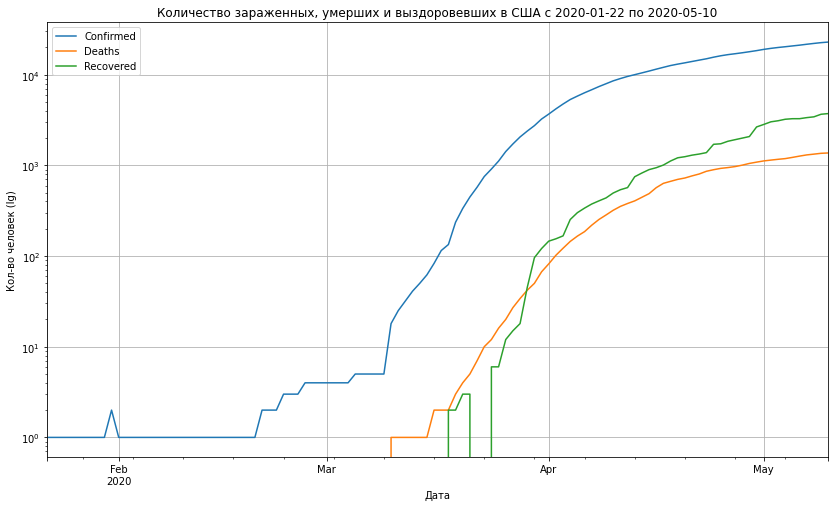

In [21]:
covid_us['Confirmed'].round().plot(figsize =(14, 8), label='Confirmed', )
covid_us['Deaths'].round().plot(label='Deaths')
covid_us['Recovered'].round().plot(label='Recovered')

plt.yscale('log')
plt.grid()
plt.ylabel('Кол-во человек (lg)')
plt.xlabel('Дата')
plt.legend()
plt.title(f'Количество зараженных, умерших и выздоровевших в США с {covid_us.index.date.min()} по {covid_us.index.date.max()}')
plt.show()

Создадим модель, которая сможет предсказывать количество заразившихся.

In [22]:
# проверим на стационарность
for i in range(100):
    p_val = ADF(covid_us['Confirmed'].diff(i).fillna(0).values, regression = 'ctt')[1]
    
    if p_val < 0.05:
        print(f'Ряд интегрированный {i} порядка, p_value = {p_val}')
        break

Ряд интегрированный 59 порядка, p_value = 0.006580107853876954


In [23]:
covid_us['Confirmed'] = covid_us['Confirmed'].fillna(0)

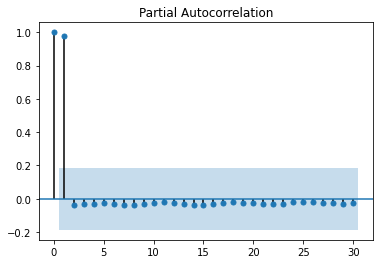

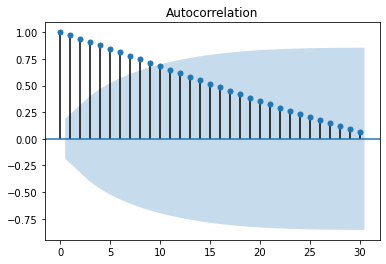

In [24]:
days = 30


plot_pacf(covid_us['Confirmed'].values, lags=days)
plot_acf(covid_us['Confirmed'].values, lags=days)
plt.show()

Так же разобъем ряд на тренировочный и тестовый, обучим модель на тренировочном и предскажем тестовый, после чего переобучим модель на всем ряде и предскажем будущие значения.

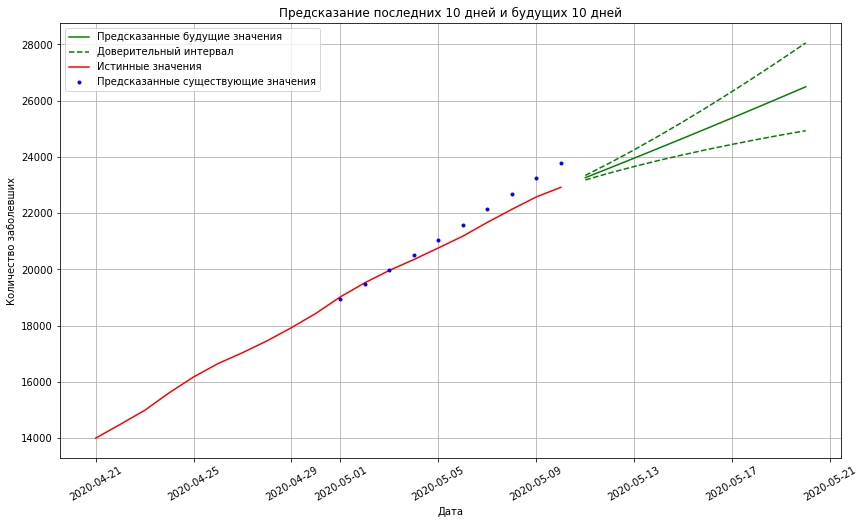

In [25]:
plt.figure(figsize =(14, 8))

N = 10
p, d, q = 1, 2, 0

model_pred_cov = ARIMA(covid_us['Confirmed'][:-N], order=(p, d, q)).fit(disp=-1)

model_future_cov = ARIMA(covid_us['Confirmed'], order=(p, d, q)).fit(disp=-1)

y_pred = model_pred_cov.predict(len(covid_us['Confirmed'][:-N]), len(covid_us['Confirmed']) - 1, typ='levels')
y_forecast = model_future_cov.forecast(N)

plt.plot(pd.date_range(start=covid_us.index[-1], periods=N+1, freq='D')[1:], y_forecast[0], 'g',
         label ='Предсказанные будущие значения')
plt.plot(pd.date_range(start=covid_us.index[-1], periods=N+1, freq='D')[1:], y_forecast[2][:, 0],'--g',
         label = 'Доверительный интервал')
plt.plot(pd.date_range(start=covid_us.index[-1], periods=N+1, freq='D')[1:], y_forecast[2][:, 1],'--g')

plt.plot(covid_us['Confirmed'][-2*N:],'r',label ='Истинные значения')
plt.plot(y_pred,'.b',label ='Предсказанные существующие значения')

plt.xlabel('Дата')
plt.ylabel('Количество заболевших')
plt.title(f'Предсказание последних {N} дней и будущих {N} дней')
plt.grid()
plt.xticks(rotation=30)
plt.legend()
plt.show()

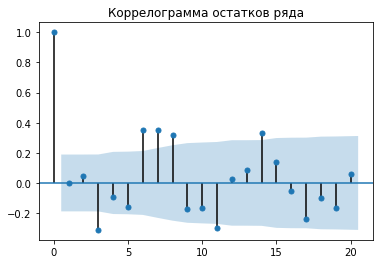

In [26]:
plot_acf(model_future_cov.resid, lags=20)
plt.title('Коррелограмма остатков ряда')
plt.show()

__5. Оцените результат моделирования.__

Модели хорошо предсказывают на несколько значений вперед, но при "удалении" от известных значений ошибка увеличивается и воронка доверительного интервала расширяется. Ее ширина зависит от характера временного ряда, если ряд выглядит линейным (как с covid), то воронка расширяется не так быстро, но из-за порядка значений ошибка может быть в несколько тысяч человек, так же ряд имеет более сложную зависимость, близкой к экспоненциальной, и точность модели на разных участках будет не равномерна. Высокий порядок интегрированности ряда не позволяет нам построить точную модель ARIMA для стационарного ряда и наша модель не полностью описывает зависимости величин, что подтверждает теорема Волда и коррелограмма остатков ряда.

Модель brent имеет более широкий доверительный интервал, что в большей степени вызвано большой дисперсией ряда и предсказывать на большой срок с разумной ошибкой мы не сможем. Модель не описывает все перегибы, но коррелограмма остатков ряда показывает, что модель выбранная правильно.